In [1]:
import matplotlib.pyplot as plt 
import scipy.misc
import numpy as np

from keras.layers import Dense, Dropout, Flatten, Input, Conv2D, Cropping2D
from keras.layers import MaxPooling2D, ZeroPadding2D, BatchNormalization
from keras.models import Model
from keras.utils.layer_utils import print_summary
from keras.preprocessing.image import ImageDataGenerator


Using TensorFlow backend.


In [2]:
train_folder = '/home/ubuntu/data/sar/experiment_crops/exp/train'
valid_folder = '/home/ubuntu/data/sar/experiment_crops/exp/valid'

train_datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)
#         shear_range=0.2,
#         zoom_range=0.2,
#         horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_folder,
        target_size=(140, 140),
        batch_size=20,
        class_mode='categorical', 
        color_mode='grayscale')

validation_generator = test_datagen.flow_from_directory(valid_folder,
        target_size=(140, 140),
        shuffle=False,
        batch_size=10,
        class_mode='categorical',
        color_mode='grayscale')

Found 2000 images belonging to 3 classes.
Found 500 images belonging to 3 classes.


In [3]:
# simple model saved weights

input_shape = (140, 140, 1)

classifier_input = Input(shape=input_shape)

p = 0.5
num_classes = 3

x = Cropping2D(cropping=((10, 10), (10, 10)))(classifier_input)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D()(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
# x = Dropout(p/2)(x)
x = Flatten()(x)
# x = Dense(128, activation='relu')
# x = Dropout(p)(x)
x = Dense(num_classes, activation='softmax')(x)

model = Model(outputs=x, inputs=classifier_input)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 140, 140, 1)       0         
_________________________________________________________________
cropping2d_1 (Cropping2D)    (None, 120, 120, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 32)      320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 30, 30, 64)        36928     
__________

In [5]:
model.optimizer.lr = 0.0001

In [7]:
model.fit_generator(
        train_generator,
        steps_per_epoch=1000,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=60)

Epoch 1/1
1000/1000 [==============================] - 514s - loss: 0.2017 - acc: 0.9242 - val_loss: 0.2249 - val_acc: 0.9200


In [6]:
model.load_weights('/home/ubuntu/data/sar/experiment_crops/exp/weights/simple_model_89valid.h5')


In [8]:
model.save_weights('/home/ubuntu/data/sar/experiment_crops/exp/weights/simple_model_92valid.h5')

In [11]:
validation_generator.reset()

In [12]:
preds = model.predict_generator(validation_generator,50)
preds.shape

(500, 3)

In [13]:
# need to figure out why the class indicies don't seem to match - needed the .reset() on the generator
files = validation_generator.filenames
predictions = np.column_stack([preds,files])
validation_generator.class_indices, train_generator.class_indices

({'oil': 0, 'other': 1, 'turbine': 2}, {'oil': 0, 'other': 1, 'turbine': 2})

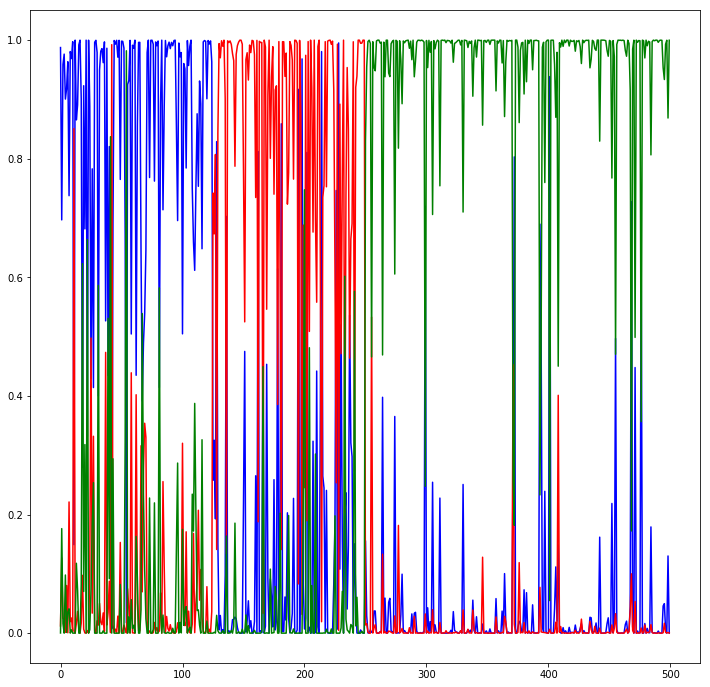

In [14]:
plt.figure(figsize=(12,12))
plt.plot(preds[:,0], 'b')
plt.plot(preds[:,1], 'r')
plt.plot(preds[:,2], 'g')
plt.show()

In [19]:
predictions[50:60]

array([['0.998303771019', '0.00167544558644', '2.07094417419e-05',
        'oil/S1B_IW_GRDH_1SDV_20170620T062130_20170620T062155_006130_00AC4E_69C1_terrain_correction_5.png'],
       ['0.997921526432', '0.0020768372342', '1.66677091329e-06',
        'oil/S1B_IW_GRDH_1SDV_20170627T061319_20170627T061344_006232_00AF47_5E1F_terrain_correction_55.png'],
       ['0.986605942249', '0.0133416373283', '5.25017312611e-05',
        'oil/S1A_IW_GRDH_1SDV_20170518T055740_20170518T055805_016632_01B98C_382D_terrain_correction_34.png'],
       ['0.669552862644', '0.00620621535927', '0.324240863323',
        'oil/S1A_IW_GRDH_1SDV_20170224T142434_20170224T142459_015427_01952A_2E6E_terrain_correction_69.png'],
       ['0.0176368094981', '0.000300316663925', '0.982062876225',
        'oil/S1A_IW_GRDH_1SDV_20170210T144138_20170210T144203_015223_018EE0_4961_terrain_correction_56.png'],
       ['0.925185739994', '0.0748143270612', '4.63344857274e-13',
        'oil/S1A_IW_GRDH_1SDV_20170210T144138_20170210T1

['0.998303771019' '0.00167544558644' '2.07094417419e-05'
 'oil/S1B_IW_GRDH_1SDV_20170620T062130_20170620T062155_006130_00AC4E_69C1_terrain_correction_5.png']


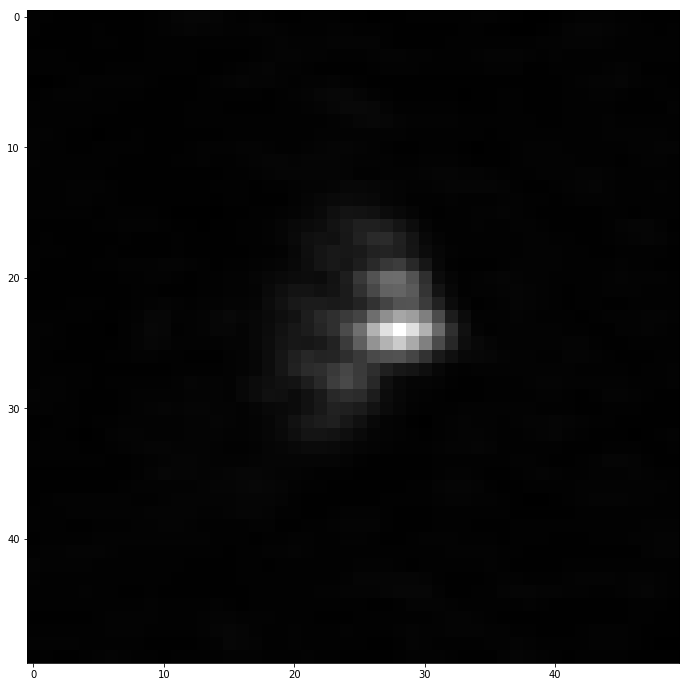

In [23]:
import cv2
print predictions[50]
valid_folder = '/home/ubuntu/data/sar/experiment_crops/exp/valid'
file_name = valid_folder + '/' + files[50]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

['0.669552862644' '0.00620621535927' '0.324240863323'
 'oil/S1A_IW_GRDH_1SDV_20170224T142434_20170224T142459_015427_01952A_2E6E_terrain_correction_69.png']


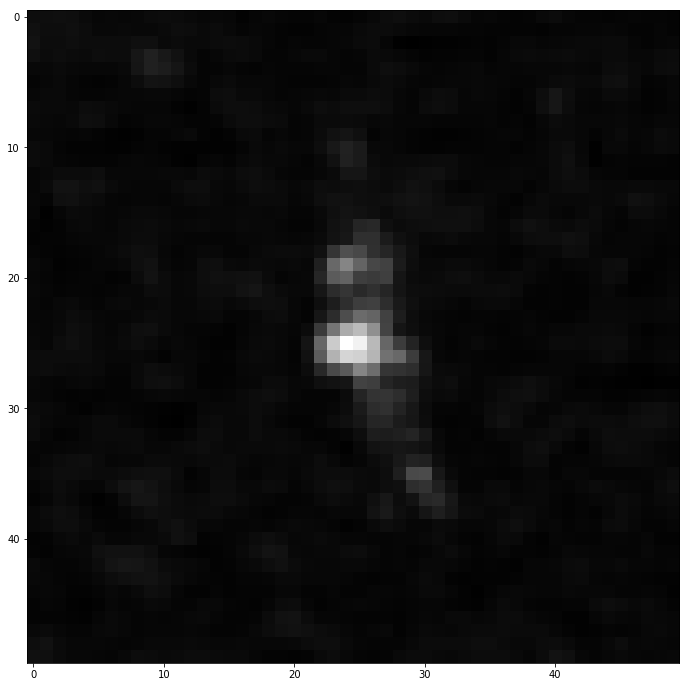

In [24]:
print predictions[53]
file_name = valid_folder + '/' + files[53]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

['0.0176368094981' '0.000300316663925' '0.982062876225'
 'oil/S1A_IW_GRDH_1SDV_20170210T144138_20170210T144203_015223_018EE0_4961_terrain_correction_56.png']


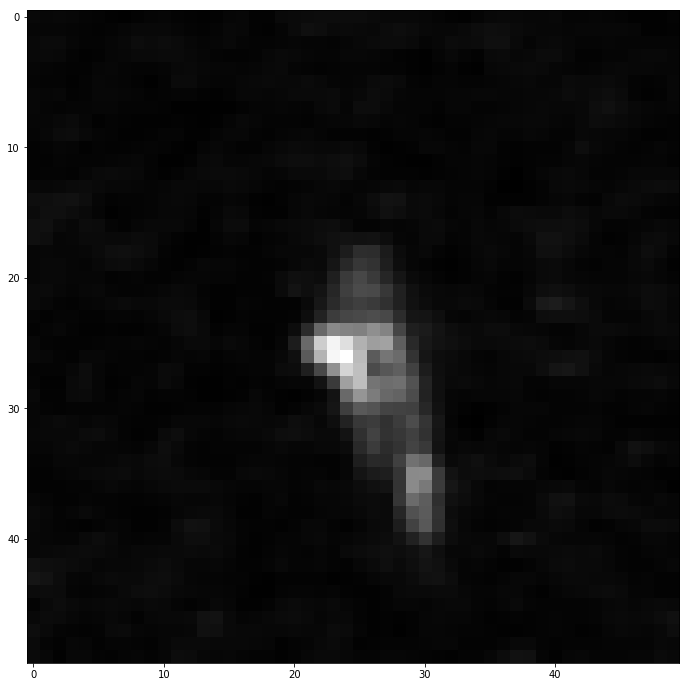

In [25]:
print predictions[54]
file_name = valid_folder + '/' + files[54]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

['0.504451870918' '0.439050555229' '0.0564974918962'
 'oil/S1A_IW_GRDH_1SDV_20170215T145000_20170215T145025_015296_019120_CCC4_terrain_correction_126.png']


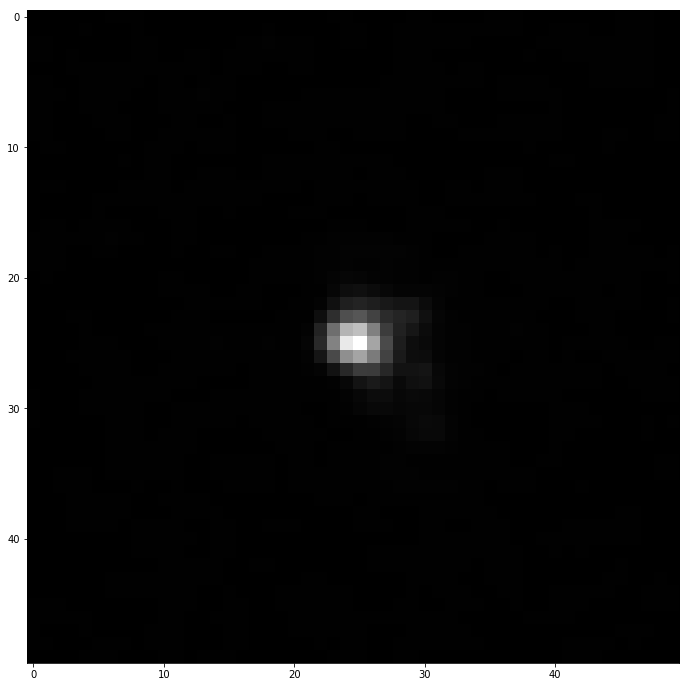

In [26]:
print predictions[58]
file_name = valid_folder + '/' + files[58]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

In [29]:
predictions[290:300]

array([['0.0332632064819', '0.0285425018519', '0.938194274902',
        'turbine/S1B_IW_GRDH_1SDV_20170517T060540_20170517T060605_005634_009DE3_01BF_terrain_correction_350.png'],
       ['0.0351213850081', '5.90875606576e-05', '0.964819550514',
        'turbine/S1A_IW_GRDH_1SDV_20170502T174100_20170502T174125_016406_01B2B3_900F_terrain_correction_475.png'],
       ['0.0030970624648', '0.000404699065257', '0.996498227119',
        'turbine/S1A_IW_GRDH_1SDV_20170516T061401_20170516T061426_016603_01B8B1_0893_terrain_correction_374.png'],
       ['0.000133595312946', '2.0912337277e-05', '0.999845504761',
        'turbine/S1A_IW_GRDH_1SDV_20170504T061401_20170504T061426_016428_01B358_C813_terrain_correction_274.png'],
       ['0.000162590207765', '5.11331818416e-05', '0.999786317348',
        'turbine/S1B_IW_GRDH_1SDV_20170508T174026_20170508T174051_005510_009A76_5D98_terrain_correction_406.png'],
       ['0.000962411460932', '9.10373273655e-06', '0.99902844429',
        'turbine/S1A_IW_GRD

['0.0994479879737' '0.00781704764813' '0.89273494482'
 'turbine/S1B_IW_GRDH_1SDV_20170405T180534_20170405T180559_005029_008CB6_15F8_terrain_correction_127.png']


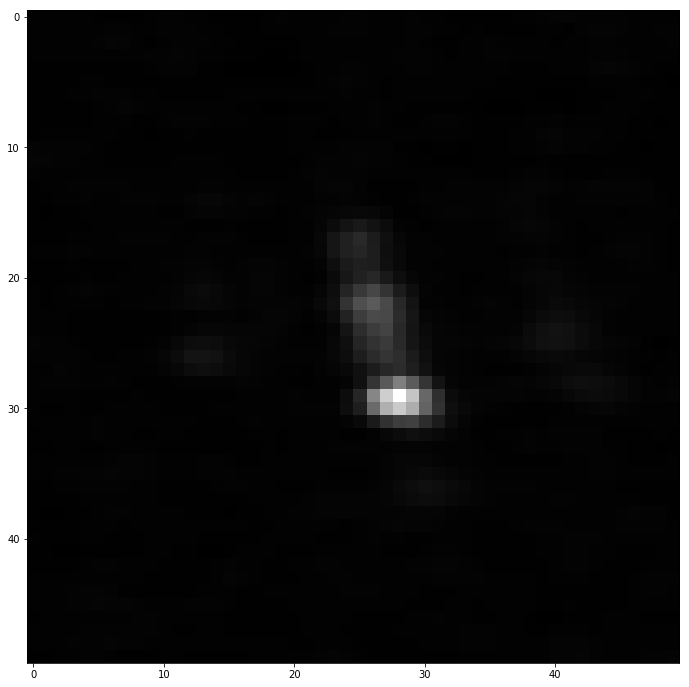

In [28]:
i = 280
print predictions[i]
file_name = valid_folder + '/' + files[i]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

['0.00330648943782' '0.000124110476463' '0.996569395065'
 'turbine/S1A_IW_GRDH_1SDV_20170502T174100_20170502T174125_016406_01B2B3_900F_terrain_correction_169.png']


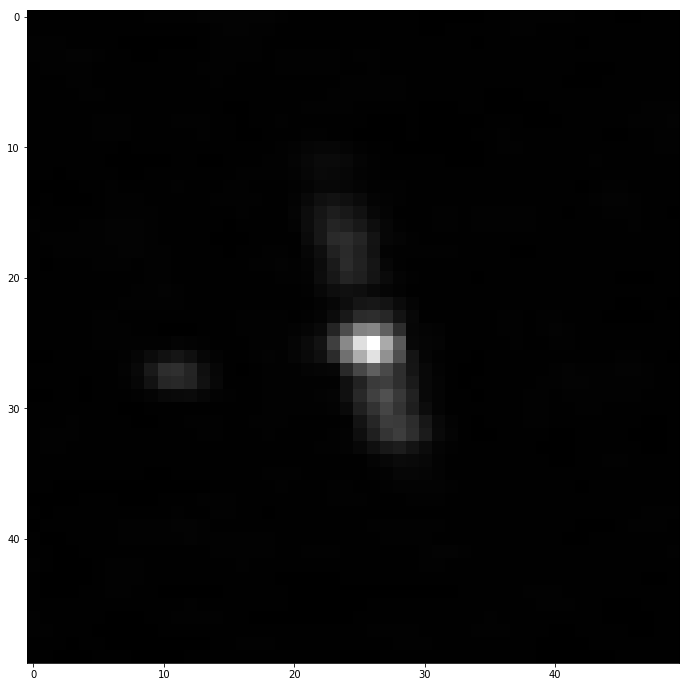

In [30]:
i = 298
print predictions[i]
file_name = valid_folder + '/' + files[i]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

['0.719951093197' '0.0324352197349' '0.247613742948'
 'turbine/S1A_IW_GRDH_1SDV_20170516T061401_20170516T061426_016603_01B8B1_0893_terrain_correction_96.png']


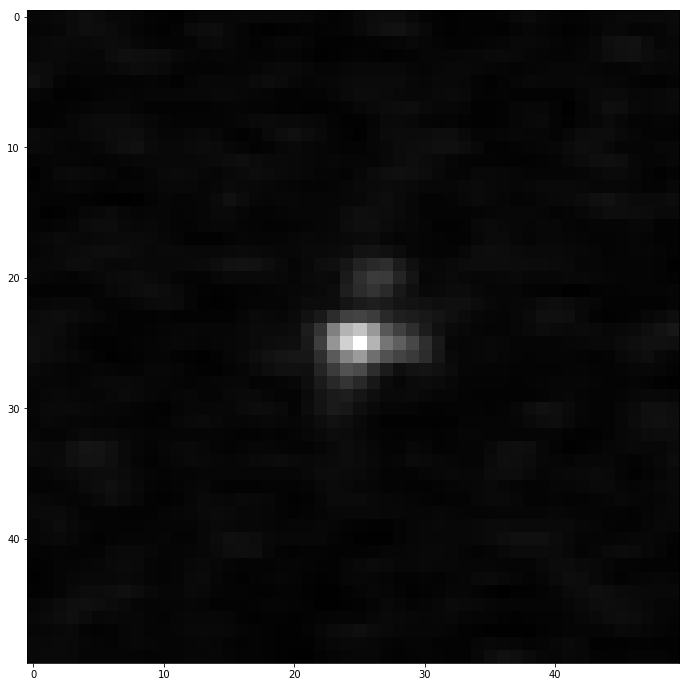

In [31]:
i = 299
print predictions[i]
file_name = valid_folder + '/' + files[i]

img = cv2.imread(file_name)

plt.figure(figsize=(12,12))
plt.imshow(img,cmap = 'gray')
plt.show()

In [ ]:
# ------------------------------------------------------------------------------------------------------------------